In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_boston
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import time

In [27]:
X = load_boston().data
Y = load_boston().target

In [30]:
print(X.shape)
# 506 samples and 13 features

(506, 13)


In [31]:
print("Mean : {}".format(X.mean()))
print("Max  : {}".format(X.max()))
print("Min  : {}".format(X.min()))

Mean : 70.07396704469443
Max  : 711.0
Min  : 0.0


In [33]:
print(Y.shape)
# Target is the house price in each sample

(506,)


In [34]:
# scaling the data for faster gradient descent
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [35]:
print("Mean : {}".format(X.mean()))
print("Max  : {}".format(X.max()))
print("Min  : {}".format(X.min()))

Mean : -1.1147462804871136e-15
Max  : 9.933930601860268
Min  : -3.9071933049810337


In [171]:
clf = SGDRegressor()
clf.fit(X, Y)
print(mean_squared_error(Y, clf.predict(X)))

23.028034816777073


#### Implementing our own gradient descent function

In [37]:
samples = X.shape[0]
iterations = 300

In [38]:
# Adding the 'bias' column with the features columns
X = np.c_[np.ones(samples), X]

In [39]:
# shuffle data X and Y
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
Y = Y[randomize]

In [40]:
Y = Y.reshape(Y.shape[0], 1)

In [41]:
X.shape

(506, 14)

In [13]:
def gradient_descent(X, Y, learning_rate=0.01, iterations=400, batch_Size=0):
    # X is matrix used for predictions along with the added bias column
    # Y target variable
    # learning rate determines the step size in the direction of gradient
    # iterations are the num of times for the algo to run
    # batch_Size=1 means SGD, 0 means GD and specify batch for mini-batch
    
    # sanity check
    assert(Y.shape == (X.shape[0], 1))
    assert(batch_Size >= 0)
    samples = X.shape[0]
    
    start = time.time()
    
    # theta initialised with random
    theta = np.random.randn(X.shape[1], 1)
    # storing the cost values per iteration to plot later
    cost_hist = np.zeros(iterations)
    
    for i_num in range(iterations):
        if batch_Size == 0:
            prediction = np.dot(X,theta)
            theta -= (1/samples) * learning_rate * np.dot(X.T, prediction-Y)
            prediction = np.dot(X,theta)
            cost_hist[i_num] = np.sum(np.square(prediction-Y)) / (2*samples)
        
        elif batch_Size == 1:
            cost = 0.0
            for s in range(samples):
                # iterate over each of the samples as they are already shuffled
                X_i = X[s,:].reshape(1,X.shape[1])
                Y_i = Y[s].reshape(1,1)
                prediction = np.dot(X_i,theta)
                theta -= learning_rate * np.dot(X_i.T, prediction-Y_i)
                prediction = np.dot(X_i,theta)
                cost += np.sum(np.square(prediction-Y_i)) / 2
            cost_hist[i_num] = cost/samples
        
        else:
            cost = 0.0
            n_batches = samples//batch_Size
            batches = np.random.permutation(samples - batch_Size +1)[:n_batches]
            for bat in batches:
                # iterate over each of the batches
                X_i = X[bat: bat + batch_Size]
                Y_i = Y[bat: bat + batch_Size]
                prediction = np.dot(X_i,theta)
                theta -= (1/batch_Size)*learning_rate*np.dot(X_i.T,prediction-Y_i)
                prediction = np.dot(X_i,theta)
                cost += np.sum(np.square(prediction-Y_i)) / (2*batch_Size)
            cost_hist[i_num] = cost/batch_Size
    
    end = time.time()
    print("Run time : {} ms".format(round((end-start)*1000, 2)))
    return theta, cost_hist

In [42]:
# Batch gradient descent
theta_gd, cost_hist_gd = gradient_descent(X, Y, 
                        iterations=iterations, batch_Size=0)

Run time : 22.72 ms


In [43]:
# stochastic gradient descent
theta_sgd, cost_hist_sgd = gradient_descent(X, Y, 
                        iterations=iterations, batch_Size=1)

Run time : 2072.1 ms


In [44]:
# mini-batch gradient descent
theta_mbgd, cost_hist_mbgd = gradient_descent(X, Y, 
                        iterations=iterations, batch_Size=25)

Run time : 118.32 ms


####  Comparing the cost history graphs

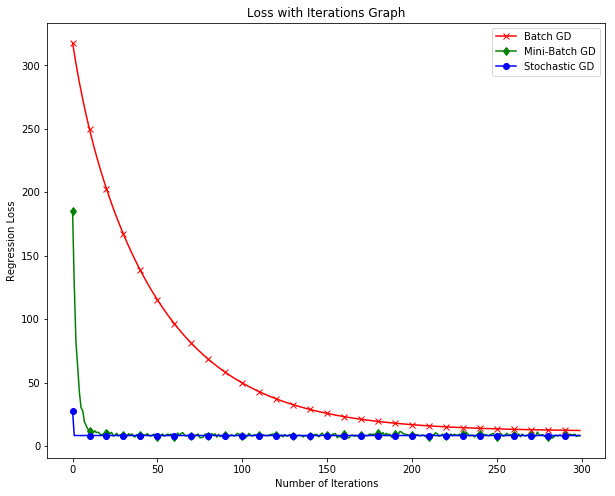

In [45]:
# Plotting the cost values with iterations graph
x_axis = range(iterations)
plt.figure(figsize=(10.0, 8.0))
markers_on = [i for i in range(iterations) if i%10 ==0]
plt.plot(x_axis, cost_hist_gd, '-rx', markevery=markers_on, 
                     label='Batch GD', )
plt.plot(x_axis, cost_hist_mbgd, '-gd', markevery=markers_on, 
                     label='Mini-Batch GD')
plt.plot(x_axis, cost_hist_sgd, '-bo', markevery=markers_on, 
                     label='Stochastic GD')
plt.xlabel("Number of Iterations")
plt.ylabel("Regression Loss")
plt.title("Loss with Iterations Graph")
plt.legend()
plt.show()

In [46]:
clf = SGDRegressor()
clf.fit(X, Y)
pred_sklearnSGD = clf.predict(X)
print(mean_squared_error(Y, pred_sklearnSGD))

22.82971463980024


#### Finding most optimal theta

In [47]:
# Since the number of features are not too large and our computational 
# power is sufficient, lets directly find the optimal value of theta by 
# using the vectorised normal equation

theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
print(theta_best)

[[ 2.25328063e+01]
 [-9.28146064e-01]
 [ 1.08156863e+00]
 [ 1.40899997e-01]
 [ 6.81739725e-01]
 [-2.05671827e+00]
 [ 2.67423017e+00]
 [ 1.94660717e-02]
 [-3.10404426e+00]
 [ 2.66221764e+00]
 [-2.07678168e+00]
 [-2.06060666e+00]
 [ 8.49268418e-01]
 [-3.74362713e+00]]


In [48]:
# Lets compare the Cost value from our gradient descent functions and the 
# one we get using the most optimal theta value, 'theta_best'

pred_best = X.dot(theta_best)
print("Error from Optimal Theta : {}".format(mean_squared_error(Y,
                                    pred_best)))
pred_gd = X.dot(theta_gd)
print("Error from Calculated Theta for Batch GD: {}".format(
                                mean_squared_error(Y, pred_gd)))
pred_mbgd = X.dot(theta_mbgd)
print("Error from Calculated Theta for Mini-Batch GD: {}".format(
                                mean_squared_error(Y, pred_mbgd)))
pred_sgd = X.dot(theta_sgd)
print("Error from Calculated Theta for Stochastic GD: {}".format(
                                mean_squared_error(Y,pred_sgd)))

print("Error from Calculated Theta for skLearn SGD: {}".format(
                                mean_squared_error(Y,pred_sklearnSGD)))

Error from Optimal Theta : 21.894831181729206
Error from Calculated Theta for Batch GD: 24.698483543800545
Error from Calculated Theta for Mini-Batch GD: 21.96812758471529
Error from Calculated Theta for Stochastic GD: 22.845951445106508
Error from Calculated Theta for skLearn SGD: 22.82971463980024


In [49]:
print("Comparing the weights from our SGD and skLearn Regressor: ")
sklSGD = clf.coef_
for i in range(len(sklSGD)):
    print("  {0:2d} :  {1: 10.8f}   -   {2: 10.8f}". format(
                    i+1,
                    theta_sgd[i][0],
                    sklSGD[i]))

Comparing the weights from our SGD and skLearn Regressor: 
   1 :   22.46789267   -    11.31434460
   2 :  -0.66849967   -   -0.66531255
   3 :   1.14203826   -    0.48237328
   4 :   0.29153106   -   -0.39389998
   5 :   0.64938312   -    0.81531448
   6 :  -1.95053319   -   -1.06691459
   7 :   2.82412889   -    3.25478057
   8 :  -0.28268455   -   -0.14535041
   9 :  -2.94866511   -   -2.10835523
  10 :   2.86720407   -    0.86533220
  11 :  -2.06102117   -   -0.39270045
  12 :  -1.61062724   -   -1.82439325
  13 :   1.28868717   -    0.93486820
  14 :  -4.43665434   -   -3.27933427


#### Comparing the predictions of our SGD, sklearn SGD and the actual Values

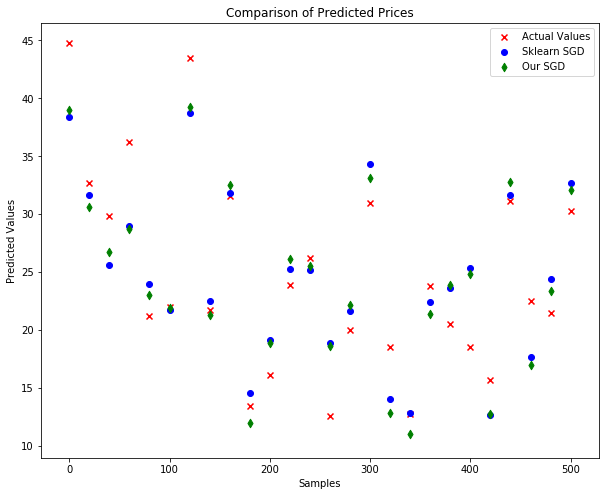

In [58]:
# Take 25 samples from the 506 samples
x_axis = [i for i in range(samples) if i%20==0]
plt.figure(figsize=(10.0, 8.0))
plt.scatter(x_axis, Y[x_axis], marker='x', 
                    color='r', label='Actual Values')
plt.scatter(x_axis, pred_sklearnSGD[x_axis], marker='o', 
                    color='b', label='Sklearn SGD')
plt.scatter(x_axis, pred_sgd[x_axis], marker='d', 
                    color='g', label='Our SGD')
plt.xlabel("Samples")
plt.ylabel("Predicted Values")
plt.title("Comparison of Predicted Prices")
plt.legend()
plt.show()

In [59]:
# Hence, we see we were able to beat the SGD regressor score but we couldn't
# surpass the score we got from the optimal value of theta 

#### Conclusions

        - Batch Gradient descent is the fastest to execute, followed by mini-batch 
        gradient descent. The stochastic gradient descent is immensely slow by around 
        95 times compared to batch.
        
        - On the other hand, we see stochastic gradient descent is fastest to converge
        around the optimal theta and batch gradient descent is the slowest. This might
        be an observation specific to this dataset. In a linear regression dataset a
        few randomly sampled points can give a good approximation of the optimal plane(which
        we are trying to fit) and that helps the stochastic and mini-batch to converge faster.
        Whereas, the batch gradient while trying to fit the theta plane over all the points 
        in each iteration, becomes slow. In more complex datasets the stochastic and mini-
        batch are expected to show a much more random behaviour.
        
        - The mini-batch gradient descent came closest to the optimum values of theta,
        which we calculated directly by solving the vectorised normal equation. The mean
        squared error in this case was even better than the sklearn SGDRegressor error value. 
        The stochastic gradient descent also came close, but the batch gradient descent has 
        little amount of error.
        
        - Overall, we can say considering the time and optimal value of theta, that the mini-
        batch gradient descent with batch size of 25 showed the best performance.